In [2]:
#from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import scipy.signal as signal

from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/epex_day_ahead_price.csv')
tests2 = pd.read_csv('/content/drive/MyDrive/spot_intraday_price.csv')
system_price = pd.read_csv('/content/drive/MyDrive/systemprice.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
temp1 = pd.read_csv('/content/drive/MyDrive/Temperature_20220312_2351.csv',names  = ('type','date','outturn','normal','high','low'),skiprows=1)
temp2 = pd.read_csv('/content/drive/MyDrive/Temperature_20220312_2352.csv',names  = ('type','date','outturn','normal','high','low'),skiprows=1)
temp3 = pd.read_csv('/content/drive/MyDrive/Temperature_20220312_2352 (1).csv',names  = ('type','date','outturn','normal','high','low'),skiprows=1)
temp4 = pd.read_csv('/content/drive/MyDrive/Temperature_20220312_2353.csv',names  = ('type','date','outturn','normal','high','low'),skiprows=1)
temp5 = pd.read_csv('/content/drive/MyDrive/Temperature_20220312_2353 (1).csv',names  = ('type','date','outturn','normal','high','low'),skiprows=1)
temp6 = pd.read_csv('/content/drive/MyDrive/Temperature_20220312_2353 (2).csv',names  = ('type','date','outturn','normal','high','low'),skiprows=1)

# **Data pre-processing and visualization**

In [4]:
datetimes = []
temp_new = pd.concat([temp1,temp2,temp3,temp4,temp5,temp6])
temp_new = temp_new[temp_new['type'] != 'FTR']
temp_new = temp_new.reset_index()
for i in range(len(temp_new['date'])):
    date = str(temp_new['date'][i])
    dt = datetime.datetime.strptime(date, '%Y%m%d')
    datetimes.append(dt)
temp_new['timestamp'] = datetimes

In [ ]:
data.head()

,timestamp,apx_da_hourly
0,2019-03-31 23:00:00+00:00,26.43
1,2019-03-31 23:30:00+00:00,26.43
2,2019-04-01 00:00:00+00:00,29.24
3,2019-04-01 00:30:00+00:00,29.24
4,2019-04-01 01:00:00+00:00,35.10


In [ ]:
tests2.head()

,timestamp,SP,spot_price
0,2019-01-02 00:00:00+00:00,1.0,40.01
1,2019-01-02 00:30:00+00:00,2.0,43.27
2,2019-01-02 01:00:00+00:00,3.0,42.72
3,2019-01-02 01:30:00+00:00,4.0,52.17
4,2019-01-02 02:00:00+00:00,5.0,53.44


<AxesSubplot:xlabel='timestamp'>

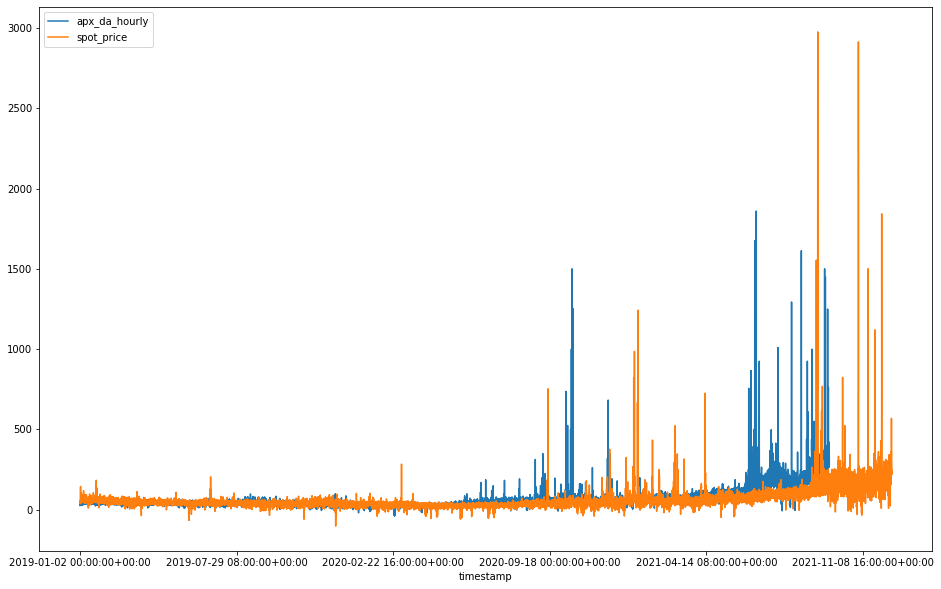

In [ ]:
ax = data.plot(figsize=(16,10))
tests2.plot(ax=ax,x="timestamp",y="spot_price")

In [5]:
trial = pd.merge(data,tests2,on="timestamp",how="inner")
trial = trial.replace(r'^\s*$', np.NaN, regex=True)
print(trial)
trial = trial.dropna()
print("DEBUG",trial)
trial = trial.reset_index()

                       timestamp  apx_da_hourly    SP  spot_price
0      2019-03-31 23:00:00+00:00          26.43  24.0      38.930
1      2019-03-31 23:30:00+00:00          26.43  25.0      38.105
2      2019-04-01 00:00:00+00:00          29.24   3.0      35.100
3      2019-04-01 00:30:00+00:00          29.24   4.0      37.770
4      2019-04-01 01:00:00+00:00          35.10   5.0      33.870
...                          ...            ...   ...         ...
47565  2021-12-16 21:30:00+00:00         287.50  44.0     232.250
47566  2021-12-16 22:00:00+00:00         249.90  45.0     242.440
47567  2021-12-16 22:30:00+00:00         249.90  46.0     220.120
47568  2021-12-16 23:00:00+00:00         240.10  47.0     231.870
47569  2021-12-16 23:30:00+00:00         240.10  48.0     246.750

[47570 rows x 4 columns]
DEBUG                        timestamp  apx_da_hourly    SP  spot_price
0      2019-03-31 23:00:00+00:00          26.43  24.0      38.930
1      2019-03-31 23:30:00+00:00          26

In [6]:
#outturn	normal	high	low
temps1,temps2,temps3,temps4,yesterday_score,twoday_score = [],[],[],[],[],[]
for i in range(len(trial)):
    d = str(trial['timestamp'][i])
    dtr = d[:10]
    if i > 48:
        yesterday_score.append(trial['apx_da_hourly'][i-48])
    else:
        yesterday_score.append(np.nan)
    if i > 96:
        twoday_score.append(trial['apx_da_hourly'][i-96])
    else:
        twoday_score.append(np.nan)
    thing = temp_new[temp_new['timestamp'] ==dtr]
    temps1.append(np.array(thing['outturn'])[0])
    temps2.append(np.array(thing['normal'])[0])
    temps3.append(np.array(thing['high'])[0])
    temps4.append(np.array(thing['low'])[0])
trial['outturn']=temps1
trial['normal']=temps2
trial['high']=temps3
trial['low']=temps4
trial['yst'] = yesterday_score
trial['twd'] = twoday_score

In [7]:
september_index = []
for i in range(len(trial)):
    st = str(trial['timestamp'][i])[:7]
    if st == '2019-09':
        september_index.append(i)
unseen = trial.iloc[september_index]
trial = trial.drop(september_index)
trial = trial.dropna()
trial = trial.reset_index()

In [8]:
import numpy as np
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor 
import numpy as np
  # arg = tf.convert_to_tensor(arg, dtype=tf.float32)


In [9]:
from copy import deepcopy
def create_features(raw_df, features,new_features, label):
    """
    Creates time series features from datetime index
    """
    df=deepcopy(raw_df[features])
    df['timestamp'] = pd.to_datetime(raw_df['timestamp'], errors='coerce')
    
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    
    X = df[new_features]
     
    y = deepcopy(raw_df[[label]])
    return X, y

features = ["SP",'low','high','outturn','yst','twd','spot_price']
# new_features = ["SP",'low','high','outturn','yst','twd','hour','dayofweek','dayofyear','dayofmonth'] # keep the best ones
new_features = features + ['hour','dayofweek','quarter','month','year', 'dayofyear','dayofmonth','weekofyear']
# new_features = features
X,y = create_features(trial, features,new_features, label="apx_da_hourly")
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,train_size=0.83)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  app.launch_new_instance()


# **XGBoost Regressor**

In [38]:
model = XGBRegressor(objective='reg:squarederror', alpha= 0.5, learning_rate= 0.1, n_estimators=1000, min_child_weight= 0.5, max_depth= 5)
model.fit(train_X,train_y)

XGBRegressor(alpha=0.5, max_depth=5, min_child_weight=0.5, n_estimators=1000,
             objective='reg:squarederror')

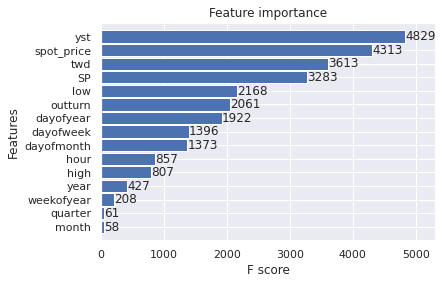

In [25]:
from xgboost import plot_importance, plot_tree
import seaborn as sns
sns.set()
_ = plot_importance(model, height=0.9)

Text(0.5, 1.0, 'Validation')

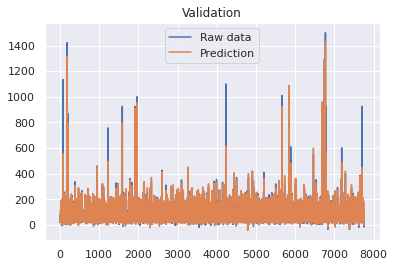

In [26]:
plt.plot(np.array(val_y),label='Raw data')
plt.plot(model.predict(val_X), label='Prediction')
plt.legend()
plt.title('Validation')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'XGBoost Regressor')

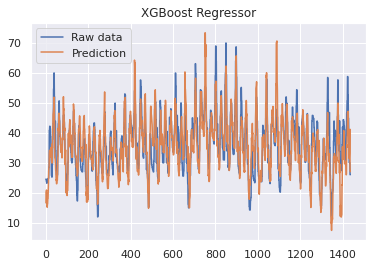

In [53]:
unseen_X,unseen_y = create_features(unseen, features,new_features, label="apx_da_hourly")
unseen_pred_y = model.predict(unseen_X[new_features])
plt.plot(np.array(unseen_y), label='Raw data')
plt.plot(unseen_pred_y, label='Prediction')
plt.legend()
plt.title('XGBoost Regressor')

Text(0.5, 0, 'Lag')

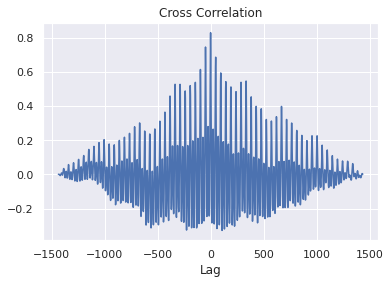

In [28]:
a = np.array(unseen_y)
b = np.array(unseen_pred_y)
l = len(b)
a = np.reshape((a - np.mean(a)) / (np.std(a) * len(a)),[1,l])
b = np.reshape((b - np.mean(b)) / (np.std(b)),[1,l])
ks = np.linspace(-len(unseen_pred_y)-1,len(unseen_pred_y)-1,len(unseen_pred_y)*2-1)
plt.plot(ks,np.reshape(signal.correlate(a,b,mode='full'),[len(ks),]))
plt.title("Cross Correlation")
plt.xlabel('Lag')

In [44]:
# adding every time feature results in the lowest error
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true=unseen_y, y_pred=unseen_pred_y)
mae = mean_absolute_error(y_true=unseen_y, y_pred=unseen_pred_y)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_true=unseen_y, y_pred=unseen_pred_y)
accuracy = 100 - mape

print("MAE for XGBoost: {}".format(mae))
print("Accuracy for XGBoost: ",accuracy,"%")

# print(mse,mae,accuracy)
# before adding the time features: Validation MAE for XGBoost: 6.386690986410313; Validation Accuracy for XGBoost:  65.83051421958581 %
# after: 5.0877223674373315 67.45336460615086 %

# params: max_depth = 5,min_child_weight = 1,subsample=0.8, colsample_bytree = 0.8, scale_pos_weight = 1
# ======> 4.894349921803219 66.66272846990479 %

# params: alpha= 0.5, learning_rate= 0.1, max_depth= 4, n_estimators=200
# ======> 4.610995241933675 65.82267901151107 %

# params: n_estimators=1000
# ======> 4.597476069716505 67.06254721422413 %

# params: n_estimators=1000, min_child_weight= 0.5, max_depth= 5
# ======> 4.331921614950202 67.18033295640177 %

# params: alpha= 0.5, learning_rate= 0.1, n_estimators=1000, min_child_weight= 0.5, max_depth= 5
# ======> 4.311481479493462 66.9131627167271 %

MAE for XGBoost: 4.346188596405437
Accuracy for XGBoost:  67.35115629064346 %


**Calculating profit**

In [54]:
ta_t = []
j = 0 
k= 0
while (j < len(pred_max)) and (k < len(pred_min)):
    if pred_max[j] > pred_min[k]:
        ta_t.append([pred_min[k],0])
        k += 1
    else:
        ta_t.append([pred_max[j],1])
        j += 1
cost = 0
rev = 0
charge = 0
for i in range(len(ta_t)):
    if ta_t[i][1] == 0:
        if charge < 1:
            cost += unseen['apx_da_hourly'].iloc[ta_t[i][0]]/2
            charge += 0.5
            if charge < 1:
                if ta_t[i+1][0] - ta_t[i][0] > 2:
                    cost += unseen['apx_da_hourly'].iloc[ta_t[i][0]+1]/2
                    charge += 0.5
    else:
        if charge > 0:
            rev += 0.85*unseen['apx_da_hourly'].iloc[ta_t[i][0]]/2
            charge -= 0.5
            if charge > 0:
                if ta_t[i+1][0] - ta_t[i][0] > 2:
                    rev += 0.85*unseen['apx_da_hourly'].iloc[ta_t[i][0]+1]/2
print('£{:.2f} Profit'.format(rev-cost))


£1217.27 Profit


# **Random Forest Regressor**

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

rf_model = RandomForestRegressor(n_estimators=100,max_depth=30)
rf_model.fit(train_X, train_y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(max_depth=30)

In [51]:
# # Calculate the mean absolute error of your Random Forest model on the validation data
unseen_X,unseen_y = create_features(unseen, features,new_features, label="apx_da_hourly")
unseen_pred_y = rf_model.predict(unseen_X[new_features])
mae = mean_absolute_error(y_true=unseen_y, y_pred=unseen_pred_y)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_true=unseen_y, y_pred=unseen_pred_y)
accuracy = 100 - mape

print("Validation MAE for Random Forest Model: {}".format(mae))
print("Validation Accuracy for Random Forest Model: ",accuracy,"%")
# n_estimators=100, max_depth=30 (slightly better than max_depth=50):
# Validation MAE for Random Forest Model: 4.353819341760566
# Validation Accuracy for Random Forest Model:  67.353985340526 %

# n_estimators=50,max_depth=10, random_state=1: 4.647466650403641   68.25732529277222 %


Validation MAE for Random Forest Model: 4.346188596405437
Validation Accuracy for Random Forest Model:  67.35115629064346 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  app.launch_new_instance()


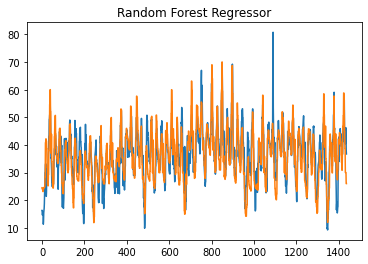

In [23]:
plt.title('Random Forest Regressor')
plt.plot(unseen_pred_y)
plt.plot(np.array(unseen_y))

# **Averaging the predictions of two models**

In [41]:
# X_kaggle_test = test[train_column]
# X_kaggle_test = pd.DataFrame(sc.fit_transform(X_kaggle_test.values), index=X_kaggle_test.index, columns=X_kaggle_test.columns)
output1 = rf_model.predict(unseen_X[new_features])
# output1=xgc.predict(X_kaggle_test).astype(int)
output2 = model.predict(unseen_X[new_features])

In [42]:
predictions=[]
for n in range(len(unseen_X)):
    combined =  (output1[n] + output2[n])/2
    predictions.append(combined)

In [43]:
mape = mean_absolute_percentage_error(y_true=unseen_y, y_pred=unseen_pred_y)
accuracy = 100 - mape
print("MAE for Random Forest Model: {}".format(mae))
print("Accuracy for Random Forest Model: ",accuracy,"%")

MAE for Random Forest Model: 4.346188596405437
Accuracy for Random Forest Model:  67.35115629064346 %


# **Parameter tuning for XGBoost Regressor**
-- GridSearchCV/TuneGridSearchCV


In [ ]:
# Parameter tuning with GridSearch CV
from sklearn.model_selection import  GridSearchCV
grid_param = {"learning_rate": [0.05, 0.15],
              "n_estimators": [500,1000],
              "alpha": [0.25, 0.75],
              'objective':['reg:squarederror'],
              "max_depth": [5, 6]}
model = XGBRegressor()
grid_mse = GridSearchCV(estimator=model, param_grid=grid_param,
                       scoring="neg_mean_squared_error",
                       cv=4, verbose=1)
grid_mse.fit(train_X, train_y)
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))
# Best parameters found:  {'alpha': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
# Best parameters found:  {'alpha': 0.25, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 1000, 'objective': 'reg:squarederror'}
# Lowest RMSE found:  18.639985671808827

In [36]:
# Parameter tuning with TuneGridSearchCV
from tune_sklearn import TuneGridSearchCV

# Example parameters to tune from SGDClassifier
parameters = {
   'colsample_bytree': [0.8],#default=1
   'subsample':[0.8],#default=1
    'min_child_weight':[0.3,0.4],#default=1
    'objective':['reg:squarederror'],
    'n_estimators':[500,1000],
    'max_depth ':[3,4],#default=6
    'gamma':[0, 0.1],#default=0
}
tune_search = TuneGridSearchCV(
    XGBRegressor(),
    parameters,
    early_stopping=True,
    max_iters=10
)
import time # Just to compare fit times
start = time.time()
tune_search.fit(train_X, train_y)
end = time.time()
print("Tune Fit Time:", end - start)
pred = tune_search.predict(val_X)
accuracy = np.count_nonzero(np.array(pred) == np.array(val_y)) / len(pred)
print("Tune Accuracy:", accuracy)
print(tune_search.best_params_)
# {'colsample_bytree': 0.8, 'subsample': 0.8, 'min_child_weight': 0.3, 'objective': 'reg:squarederror', 'max_depth ': 4}

/usr/local/lib/python3.7/dist-packages/tune_sklearn/tune_basesearch.py:441: UserWarning: tune-sklearn implements incremental learning for xgboost models following this: https://github.com/dmlc/xgboost/issues/1686. This may negatively impact performance. To disable, set `early_stopping=False`.
  category=UserWarning)
/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:379: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "
Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.
SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to s

Tune Fit Time: 3514.0153143405914
Tune Accuracy: 0.0
{'colsample_bytree': 0.8, 'subsample': 0.8, 'min_child_weight': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 500, 'max_depth ': 3, 'gamma': 0.1}
